# Model Uncertainty and Calibration in Deep Learning

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis Wilson, Jérémy Pirard | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Introduction

Modern deep learning models can achieve impressive accuracy, but **knowing when to trust a model's predictions** is equally important. Consider these scenarios:

- A medical diagnosis system predicts cancer with 95% confidence, but should we trust it?
- An autonomous vehicle classifies an object with high confidence—is it actually certain?
- A model says "90% confident" for 100 predictions—will exactly 90 of them be correct?

This notebook explores two fundamental concepts:

1. **Uncertainty Quantification**: How uncertain is the model about its predictions?
2. **Calibration**: Does the model's confidence match its actual accuracy?

These concepts are crucial for:
- **Safety-critical applications**: Medicine, autonomous driving, finance
- **Decision making**: Knowing when to defer to humans or request more information
- **Active learning**: Selecting which data points to label next
- **Out-of-distribution detection**: Identifying inputs the model hasn't seen before
- **Building trust**: Users need to know when the model is reliable

### What We'll Cover

1. **Uncertainty Quantification**: Different types of uncertainty and how to estimate them
2. **Calibration Metrics**: How to measure if a model's confidence is trustworthy
3. **Calibration Techniques**: Methods to improve model calibration

## Installation and Setup

In [1]:
# Install required packages for Colab
!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, mobilenet_v2
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from typing import Tuple

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


### Loading Data and Models

We'll use CIFAR-10 and pretrained models adapted for this dataset.

In [ ]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Mapping from CIFAR-10 index to ImageNet index
cifar_to_imagenet_map = {
    0: 404,  # airplane -> airliner
    1: 817,  # automobile -> sports car
    2: 15,   # bird -> robin
    3: 281,  # cat -> tabby
    4: 353,  # deer -> hartebeest
    5: 207,  # dog -> golden retriever
    6: 30,   # frog -> bullfrog
    7: 339,  # horse -> sorrel
    8: 510,  # ship -> container ship
    9: 867,  # truck -> trailer truck
}

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Sample a subset for faster computation (100 images per class)
n_samples_per_class = 100
indices = []
for i in range(10):
    class_indices = [idx for idx, (_, label) in enumerate(testset) if label == i]
    indices.extend(class_indices[:n_samples_per_class])

subset = torch.utils.data.Subset(testset, indices)
dataloader = torch.utils.data.DataLoader(subset, batch_size=len(subset), shuffle=False)

# Get all images and labels
images, labels = next(iter(dataloader))
print(f'Dataset shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

# Prepare model
model = mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()

# ImageNet preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]),
])

# Load ImageNet class names
with open('imagenet_classes.txt', 'r') as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

print(f'Loaded {len(imagenet_classes)} ImageNet classes')

Dataset shape: torch.Size([1000, 3, 32, 32])
Labels shape: torch.Size([1000])
Loaded 1000 ImageNet classes


/opt/homebrew/anaconda3/envs/cozero/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/cozero/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Part 1: Uncertainty Quantification

### Theoretical Background

In deep learning, **uncertainty** refers to the model's lack of confidence in its predictions. Understanding uncertainty is crucial for:
- Knowing when predictions are reliable
- Identifying out-of-distribution inputs
- Active learning (selecting informative samples to label)
- Safe deployment in critical applications

#### Types of Uncertainty

There are two fundamental types of uncertainty:

**1. Aleatoric Uncertainty (Data Uncertainty)**
- Uncertainty inherent in the data itself
- Cannot be reduced with more training data or a better model
- Examples:
  - An image is genuinely ambiguous (e.g., a blurry photo)
  - A patient has symptoms consistent with multiple diseases
  - Measurement noise in sensors

**2. Epistemic Uncertainty (Model Uncertainty)**
- Uncertainty due to lack of knowledge or training data
- Can be reduced with more data or better models
- Examples:
  - Model hasn't seen similar examples during training
  - Insufficient training data for a particular class
  - Model architecture limitations

#### Measuring Uncertainty

For a classification model outputting probabilities $p(y|x)$, we can measure uncertainty using:

**1. Predictive Entropy**

Measures the spread of the probability distribution:

$$H[y|x] = -\sum_{c=1}^C p(y=c|x) \log p(y=c|x)$$

- High entropy → high uncertainty (uniform distribution)
- Low entropy → low uncertainty (peaked distribution)
- Range: $[0, \log C]$ where $C$ is the number of classes

**2. Maximum Confidence**

Simply the highest predicted probability:

$$\max_c p(y=c|x)$$

- High value → model is confident
- Low value → model is uncertain
- Range: $[\frac{1}{C}, 1]$

**3. Mutual Information (for Epistemic Uncertainty)**

Requires multiple model predictions (e.g., from dropout or ensembles):

$$I[y; \theta | x] = H[y|x] - \mathbb{E}_{\theta}[H[y|x,\theta]]$$

This measures disagreement between different model instantiations.

### Basic Uncertainty Estimation

Let's start by computing basic uncertainty measures from model predictions.

In [ ]:
def get_predictions(model, dataloader, device):
    """
    Get predictions and ground truth for entire dataset.

    Returns:
        logits: raw model outputs (N, C)
        probs: softmax probabilities (N, C)
        preds: predicted classes (N,)
        labels: ground truth labels (N,)
    """
    model.eval()
    all_logits = []
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            input_tensor = preprocess(images)
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_logits.append(outputs.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(predicted.cpu())
            all_labels.append(labels)

    return (torch.cat(all_logits).numpy(),
            torch.cat(all_probs).numpy(),
            torch.cat(all_preds).numpy(),
            torch.cat(all_labels).numpy())

def compute_entropy(probs):
    """
    Compute predictive entropy.

    Args:
        probs: probability distributions (N, C)
    Returns:
        entropy: array of shape (N,)
    """
    return -np.sum(probs * np.log(probs + 1e-10), axis=1)

def compute_confidence(probs):
    """
    Compute maximum confidence (max probability).

    Args:
        probs: probability distributions (N, C)
    Returns:
        confidence: array of shape (N,)
    """
    return np.max(probs, axis=1)

In [ ]:
# Get predictions from the model
logits_true, probs_true, preds_true, labels_cifar = get_predictions(model, dataloader, device)

# Map CIFAR labels to ImageNet labels
labels_true = np.array([cifar_to_imagenet_map[c] for c in labels_cifar])

n_samples = len(labels_true)
n_classes = 1000

print(f"Dataset size: {n_samples}")
print(f"Model accuracy: {accuracy_score(labels_true, preds_true):.3f}")

Dataset size: 1000
Model accuracy: 0.000


In [ ]:
# Compute uncertainty measures
entropy = compute_entropy(probs_true)
confidence = compute_confidence(probs_true)

# Determine correct predictions
correct = (preds_true == labels_true)

print(f"Mean entropy: {entropy.mean():.3f}")
print(f"Mean confidence: {confidence.mean():.3f}")
print(f"Accuracy: {correct.mean():.3f}")

Mean entropy: 2.831
Mean confidence: 0.370
Accuracy: 0.000


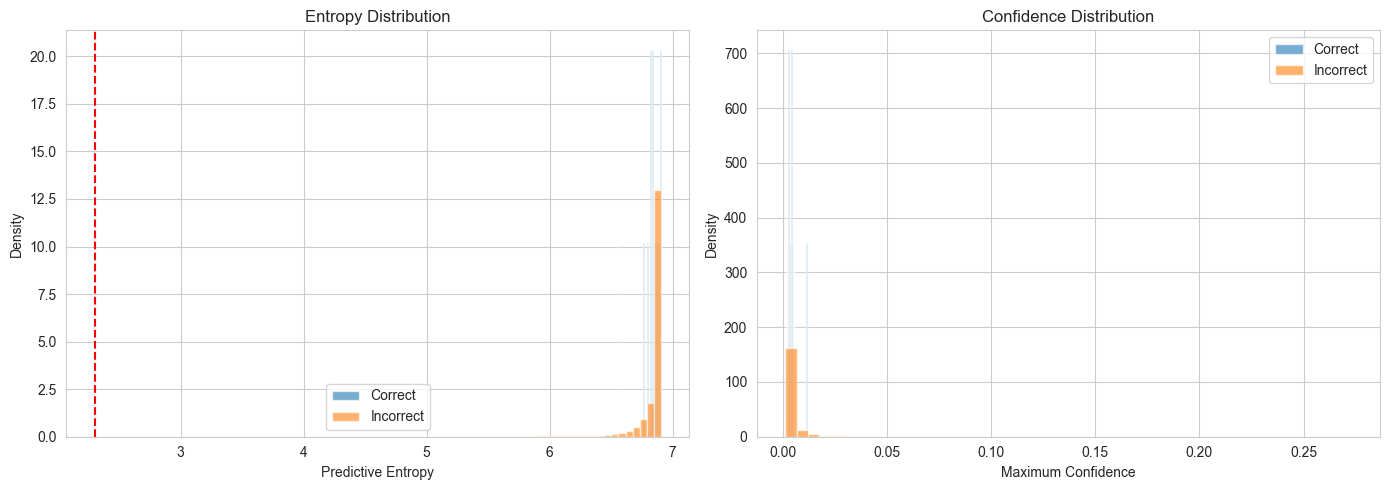

In [ ]:
# Visualize uncertainty distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy distribution
axes[0].hist(entropy[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[0].hist(entropy[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[0].set_xlabel('Predictive Entropy')
axes[0].set_ylabel('Density')
axes[0].set_title('Entropy Distribution')
axes[0].legend()
axes[0].axvline(np.log(n_classes), color='red', linestyle='--',
                label=f'Max entropy ({np.log(n_classes):.2f})')

# Confidence distribution
axes[1].hist(confidence[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[1].hist(confidence[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[1].set_xlabel('Maximum Confidence')
axes[1].set_ylabel('Density')
axes[1].set_title('Confidence Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

**Observation**:
- Correct predictions tend to have **lower entropy** (more peaked distributions)
- Correct predictions tend to have **higher confidence**
- However, there's significant overlap—the model can be wrong even when confident!

### Monte Carlo Dropout for Epistemic Uncertainty

**MC Dropout** is a powerful technique to estimate epistemic uncertainty:

1. Train a model with dropout layers
2. At test time, keep dropout **enabled**
3. Make multiple forward passes (typically 10-50)
4. Each pass gives a different prediction due to random dropout
5. Disagreement between passes indicates epistemic uncertainty

**Key insight**: Dropout at test time approximates Bayesian inference over model weights. Each forward pass samples from an approximate posterior distribution over models.

#### Mathematical Foundation

For $T$ stochastic forward passes with dropout:

$$p(y|x) \approx \frac{1}{T} \sum_{t=1}^T p(y|x, \theta_t)$$

where $\theta_t$ represents the $t$-th dropout mask.

**Predictive Entropy** (total uncertainty):
$$H[y|x] = -\sum_c \bar{p}_c \log \bar{p}_c$$

where $\bar{p}_c = \frac{1}{T}\sum_t p_t(y=c|x)$

**Expected Entropy** (aleatoric uncertainty):
$$\mathbb{E}[H[y|x, \theta]] = \frac{1}{T} \sum_t H[y|x, \theta_t]$$

**Mutual Information** (epistemic uncertainty):
$$I[y; \theta | x] = H[y|x] - \mathbb{E}[H[y|x, \theta]]$$

In [ ]:
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

def mc_dropout_predictions(model, dataloader, device, n_samples=10):
    """
    Get multiple predictions using MC Dropout.

    Returns:
        probs_samples: list of probability arrays, each of shape (N, C)
    """
    model.eval()
    enable_dropout(model)

    probs_samples = []

    for i in range(n_samples):
        all_probs = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                input_tensor = preprocess(images)
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())
        concatenated_probs = torch.cat(all_probs).numpy()
        probs_samples.append(concatenated_probs)

    return probs_samples

def compute_mc_uncertainty(probs_samples):
    """
    Compute uncertainty measures from MC dropout samples.

    Args:
        probs_samples: list of T arrays, each of shape (N, C)

    Returns:
        mean_probs: mean predictions (N, C)
        predictive_entropy: total uncertainty (N,)
        expected_entropy: aleatoric uncertainty (N,)
        mutual_info: epistemic uncertainty (N,)
    """
    probs_array = np.array(probs_samples)  # (T, N, C)

    # Mean prediction
    mean_probs = np.mean(probs_array, axis=0)  # (N, C)

    # Predictive entropy (total uncertainty)
    predictive_entropy = compute_entropy(mean_probs)

    # Expected entropy (aleatoric uncertainty)
    entropies = np.array([compute_entropy(probs) for probs in probs_samples])
    expected_entropy = np.mean(entropies, axis=0)

    # Mutual information (epistemic uncertainty)
    mutual_info = predictive_entropy - expected_entropy

    return mean_probs, predictive_entropy, expected_entropy, mutual_info

In [ ]:
# Get MC dropout predictions
# Warning: Running this can take a while !
n_mc_samples = 2 # usually 10 or 20
mc_probs_samples = mc_dropout_predictions(model, dataloader, device, n_samples=n_mc_samples)

# Compute MC uncertainties
mean_probs, pred_entropy, aleatory, epistemic = compute_mc_uncertainty(mc_probs_samples)

print(f"Mean predictive entropy: {pred_entropy.mean():.3f}")
print(f"Mean aleatoric uncertainty: {aleatory.mean():.3f}")
print(f"Mean epistemic uncertainty: {epistemic.mean():.3f}")

Mean predictive entropy: 1.598
Mean aleatoric uncertainty: 1.596
Mean epistemic uncertainty: 0.002


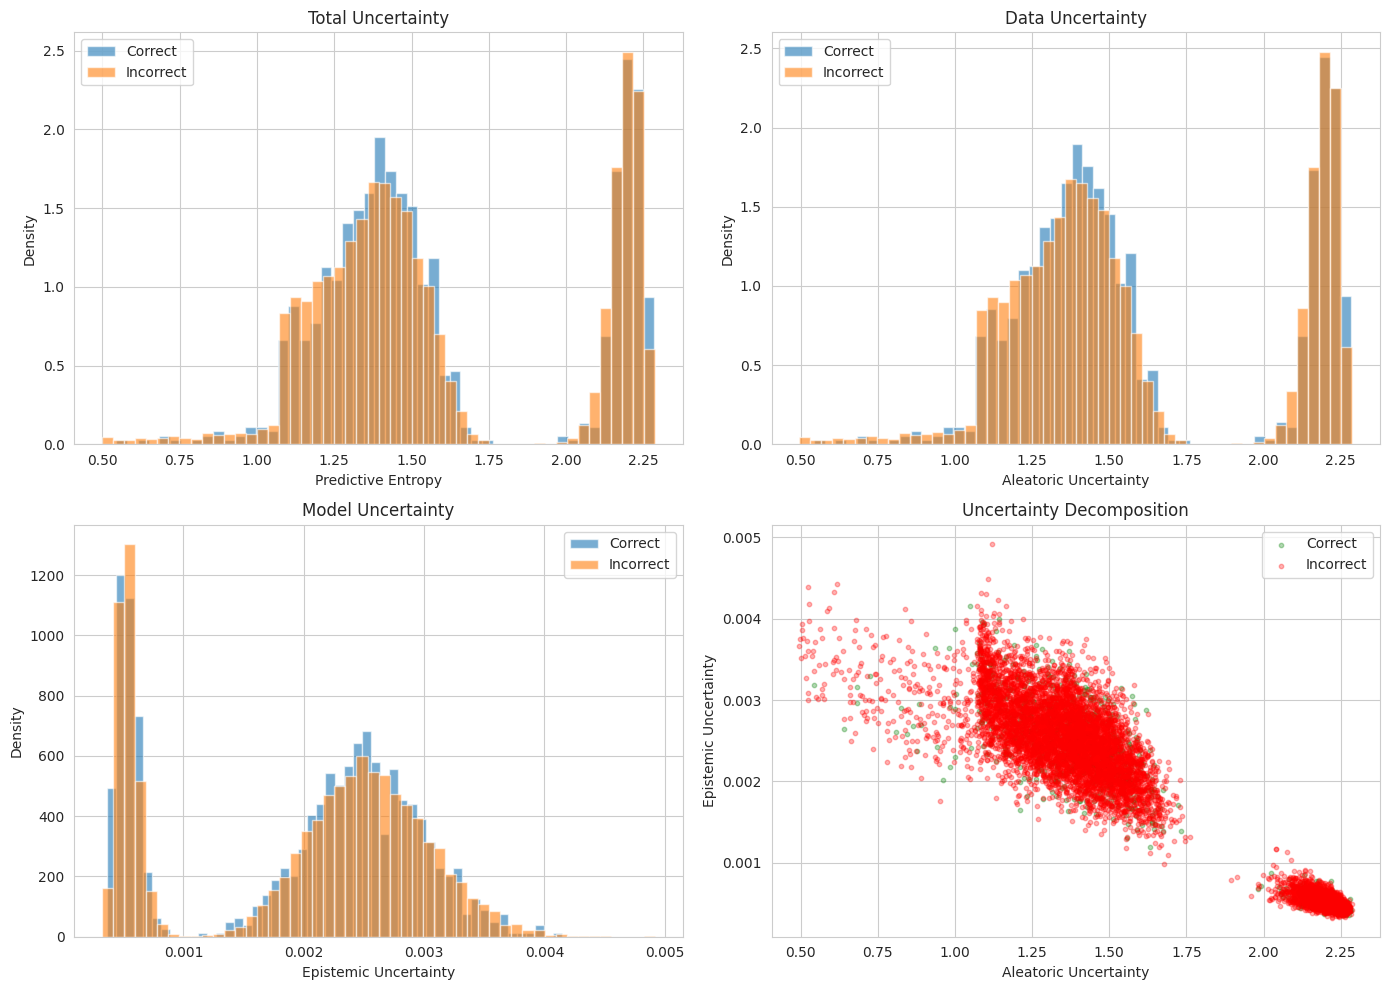

In [ ]:
# Get labels from dataloader
labels_true = np.array([cifar_to_imagenet_map[c.item()] for c in labels])

# Determine correct predictions for the MC dropout predictions
mean_preds = np.argmax(mean_probs, axis=1)
correct = (mean_preds == labels_true)

# Visualize uncertainty decomposition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Predictive entropy
axes[0, 0].hist(pred_entropy[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[0, 0].hist(pred_entropy[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[0, 0].set_xlabel('Predictive Entropy')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Total Uncertainty')
axes[0, 0].legend()

# Aleatoric uncertainty
axes[0, 1].hist(aleatory[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[0, 1].hist(aleatory[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[0, 1].set_xlabel('Aleatoric Uncertainty')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Data Uncertainty')
axes[0, 1].legend()

# Epistemic uncertainty
axes[1, 0].hist(epistemic[correct], bins=50, alpha=0.6, label='Correct', density=True)
axes[1, 0].hist(epistemic[~correct], bins=50, alpha=0.6, label='Incorrect', density=True)
axes[1, 0].set_xlabel('Epistemic Uncertainty')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Model Uncertainty')
axes[1, 0].legend()

# Scatter: epistemic vs aleatoric
axes[1, 1].scatter(aleatory[correct], epistemic[correct],
                  alpha=0.3, s=10, label='Correct', c='green')
axes[1, 1].scatter(aleatory[~correct], epistemic[~correct],
                  alpha=0.3, s=10, label='Incorrect', c='red')
axes[1, 1].set_xlabel('Aleatoric Uncertainty')

axes[1, 1].set_ylabel('Epistemic Uncertainty')
axes[1, 1].set_title('Uncertainty Decomposition')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**Interpretation**:

- **Predictive entropy**: Total uncertainty about the prediction
- **Aleatoric uncertainty**: Irreducible uncertainty from the data itself
- **Epistemic uncertainty**: Uncertainty due to the model (reducible with more data/training)

Incorrect predictions often show:
- Higher epistemic uncertainty → model is uncertain which class it should be
- This is valuable information for active learning and safety-critical systems

<div class="alert alert-warning">
<b>Exercise 1 (15 minutes): Comparing Uncertainty Estimation Methods</b>

Your task is to compare different uncertainty estimation approaches:

1. **Single prediction uncertainty** (predictive entropy from one forward pass)
2. **MC Dropout uncertainty** (using the epistemic uncertainty we computed)

For each method:
1. Identify the top 100 most uncertain predictions
2. Compute the accuracy on these uncertain samples
3. Compare:
   - Which method best identifies incorrect predictions?
   - How do the uncertainty scores differ?
   - Plot a comparison of the three methods

**Questions to answer:**
- Does higher uncertainty correlate with lower accuracy?
- Which method gives the most useful uncertainty signal?
- When might you prefer one method over another?

**Bonus**: Create a rejection mechanism: refuse to predict on the top-K most uncertain examples. Plot accuracy vs. rejection rate for each method.
</div>

In [ ]:
# Your code here for Exercise 1



## Part 2: Calibration Metrics

### Theoretical Background

**Calibration** measures whether a model's predicted confidence matches its actual accuracy. A perfectly calibrated model means:

> *Among all predictions where the model predicts probability $p$, exactly $p$ fraction should be correct.*

For example:
- If a model says "90% confident" for 100 predictions, exactly 90 should be correct
- If it says "70% confident" for 50 predictions, exactly 35 should be correct

#### Why Calibration Matters

Calibration is crucial for:
- **Decision making**: Using predicted probabilities to make cost-sensitive decisions
- **Risk assessment**: Knowing actual confidence for safety-critical applications
- **Combining models**: Ensembling requires well-calibrated probabilities
- **Human trust**: People need reliable confidence scores to trust AI systems

#### The Problem with Modern Neural Networks

Recent research shows that modern deep neural networks are often **poorly calibrated**:
- They tend to be **overconfident**: predicted probabilities are too high
- Deeper models and larger datasets can worsen calibration
- Regularization techniques (dropout, weight decay) can hurt calibration

**Example**: A model might predict 0.95 confidence but only be correct 0.75 of the time.

### Reliability Diagrams

A **reliability diagram** (or calibration plot) visualizes calibration:

1. Group predictions into bins based on their confidence (e.g., [0.0-0.1], [0.1-0.2], ..., [0.9-1.0])
2. For each bin, compute:
   - Average predicted confidence
   - Actual accuracy (fraction of correct predictions)
3. Plot accuracy vs. confidence

**Perfect calibration**: Points lie on the diagonal (predicted confidence = actual accuracy)

**Common patterns**:
- **Above diagonal**: Model is underconfident (predicts lower probabilities than actual accuracy)
- **Below diagonal**: Model is overconfident (predicts higher probabilities than actual accuracy)

In [ ]:
def compute_calibration_bins(confidences, predictions, labels, n_bins=10):
    """
    Compute calibration metrics for reliability diagram.

    Args:
        confidences: predicted confidences (max probability)
        predictions: predicted classes
        labels: true labels
        n_bins: number of bins for grouping

    Returns:
        bin_confidences: average confidence in each bin
        bin_accuracies: accuracy in each bin
        bin_counts: number of samples in each bin
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_confidences = []
    bin_accuracies = []
    bin_counts = []

    for i in range(n_bins):
        # Find predictions in this bin
        in_bin = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i + 1])

        if np.sum(in_bin) > 0:
            # Average confidence in bin
            bin_conf = np.mean(confidences[in_bin])
            # Accuracy in bin
            bin_acc = np.mean(predictions[in_bin] == labels[in_bin])
            # Count
            count = np.sum(in_bin)

            bin_confidences.append(bin_conf)
            bin_accuracies.append(bin_acc)
            bin_counts.append(count)
        else:
            bin_confidences.append(np.nan)
            bin_accuracies.append(np.nan)
            bin_counts.append(0)

    return np.array(bin_confidences), np.array(bin_accuracies), np.array(bin_counts)

def plot_reliability_diagram(confidences, predictions, labels, n_bins=10, title=""):
    """
    Plot reliability diagram.
    """
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        confidences, predictions, labels, n_bins)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Reliability diagram
    # Filter out empty bins
    valid = ~np.isnan(bin_conf)

    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax1.plot(bin_conf[valid], bin_acc[valid], 'o-', linewidth=2,
             markersize=8, label='Model')

    # Add bar chart showing distribution of predictions
    gap = bin_acc - bin_conf
    ax1.bar(bin_conf[valid], gap[valid], width=0.1/n_bins*10,
            alpha=0.3, edgecolor='black', label='Gap')

    ax1.set_xlabel('Confidence', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Reliability Diagram' + (f'\n{title}' if title else ''))
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    # Confidence histogram
    ax2.bar(range(n_bins), bin_counts, width=0.8, alpha=0.7)
    ax2.set_xlabel('Confidence Bin', fontsize=12)
    ax2.set_ylabel('Number of Predictions', fontsize=12)
    ax2.set_title('Confidence Histogram')
    ax2.set_xticks(range(n_bins))
    ax2.set_xticklabels([f'{i/n_bins:.1f}' for i in range(n_bins)], rotation=45)

    plt.tight_layout()
    plt.show()

    return bin_conf, bin_acc, bin_counts

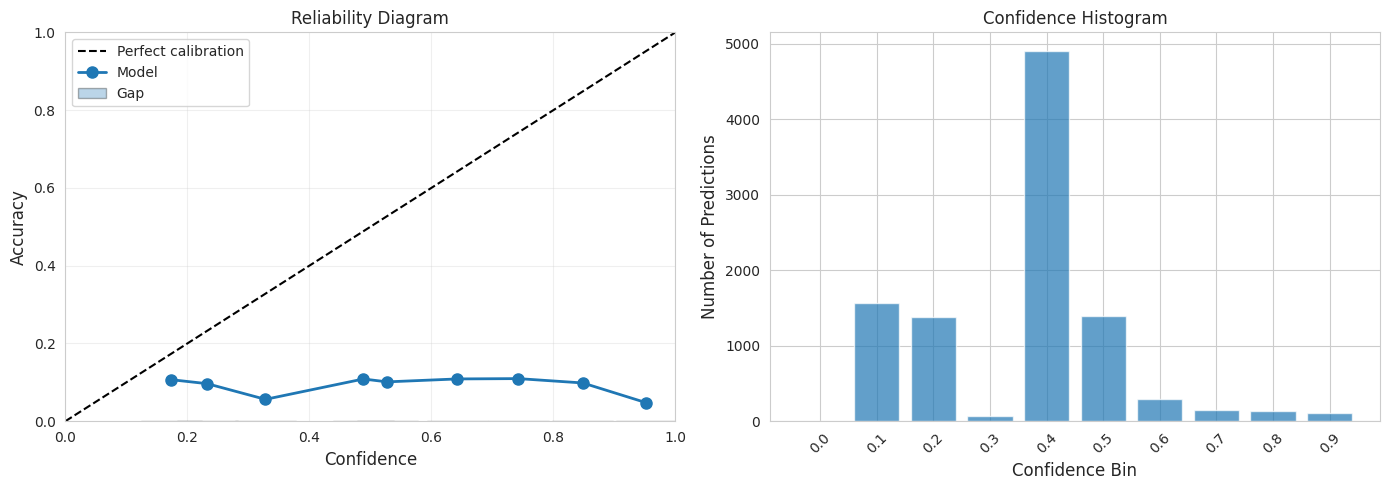

In [ ]:
# Plot reliability diagram for our model
bin_conf, bin_acc, bin_counts = plot_reliability_diagram(
    confidence, preds_true, labels_true, n_bins=10)

**Interpretation**:
- The **reliability diagram** (left) shows how well confidence matches accuracy
- Points below the diagonal indicate **overconfidence**
- The **bars** show the calibration error for each bin
- The **histogram** (right) shows the distribution of confidence scores

A well-calibrated model has points close to the diagonal line.

### Expected Calibration Error (ECE)

The **Expected Calibration Error** quantifies calibration with a single number:

$$ECE = \sum_{m=1}^M \frac{|B_m|}{n} |acc(B_m) - conf(B_m)|$$

where:
- $M$ is the number of bins
- $B_m$ is the set of predictions in bin $m$
- $|B_m|$ is the number of predictions in bin $m$
- $n$ is the total number of predictions
- $acc(B_m)$ is the accuracy in bin $m$
- $conf(B_m)$ is the average confidence in bin $m$

**Interpretation**:
- ECE = 0: Perfect calibration
- Higher ECE: Worse calibration
- Typical range: 0-0.2 for most models

### Maximum Calibration Error (MCE)

MCE measures the worst-case calibration error:

$$MCE = \max_{m \in \{1,...,M\}} |acc(B_m) - conf(B_m)|$$

**Interpretation**:
- More conservative than ECE
- Highlights the worst calibrated bin
- Important for safety-critical applications

In [ ]:
def compute_ece(confidences, predictions, labels, n_bins=10):
    """
    Compute Expected Calibration Error.
    """
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        confidences, predictions, labels, n_bins)

    valid = ~np.isnan(bin_conf)
    ece = np.sum(bin_counts[valid] * np.abs(bin_acc[valid] - bin_conf[valid])) / np.sum(bin_counts)

    return ece

def compute_mce(confidences, predictions, labels, n_bins=10):
    """
    Compute Maximum Calibration Error.
    """
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        confidences, predictions, labels, n_bins)

    valid = ~np.isnan(bin_conf)
    mce = np.max(np.abs(bin_acc[valid] - bin_conf[valid]))

    return mce

# Compute calibration metrics
ece = compute_ece(confidence, preds_true, labels_true)
mce = compute_mce(confidence, preds_true, labels_true)

print(f"Expected Calibration Error (ECE): {ece:.4f}")
print(f"Maximum Calibration Error (MCE): {mce:.4f}")


Expected Calibration Error (ECE): 0.3216
Maximum Calibration Error (MCE): 0.9047

Accuracy: 0.1046


### Comparing Multiple Models

Let's simulate different scenarios to understand calibration better.

In [ ]:
def simulate_model(n_samples, n_classes, calibration='good'):
    """
    Simulate a model with different calibration properties.

    Args:
        calibration: 'good', 'overconfident', or 'underconfident'
    """
    if calibration == 'good':
        # Well-calibrated model
        probs = np.random.dirichlet(np.ones(n_classes) * 2, n_samples)
        # Set true class to have highest probability
        labels = np.random.randint(0, n_classes, n_samples)
        for i in range(n_samples):
            if np.random.rand() < 0.7:  # 70% accuracy
                probs[i] = np.random.dirichlet(np.ones(n_classes) * 0.5)
                probs[i, labels[i]] = np.random.uniform(0.7, 0.95)
                probs[i] = probs[i] / probs[i].sum()

    elif calibration == 'overconfident':
        # Overconfident model
        probs = np.random.dirichlet(np.ones(n_classes) * 0.1, n_samples)
        labels = np.random.randint(0, n_classes, n_samples)
        for i in range(n_samples):
            if np.random.rand() < 0.6:  # Only 60% accuracy
                probs[i, labels[i]] = np.random.uniform(0.85, 0.99)
                probs[i] = probs[i] / probs[i].sum()

    else:  # underconfident
        # Underconfident model
        probs = np.random.dirichlet(np.ones(n_classes) * 5, n_samples)
        labels = np.random.randint(0, n_classes, n_samples)
        for i in range(n_samples):
            if np.random.rand() < 0.75:  # 75% accuracy
                probs[i, labels[i]] = np.random.uniform(0.4, 0.6)
                probs[i] = probs[i] / probs[i].sum()

    preds = np.argmax(probs, axis=1)
    return probs, preds, labels

In [ ]:
# Compare different calibration scenarios
scenarios = ['good', 'overconfident', 'underconfident']
results = {}

for scenario in scenarios:
    probs, preds, labels = simulate_model(5000, 10, calibration=scenario)
    conf = np.max(probs, axis=1)

    acc = accuracy_score(labels, preds)
    ece = compute_ece(conf, preds, labels)
    mce = compute_mce(conf, preds, labels)

    results[scenario] = {
        'accuracy': acc,
        'ece': ece,
        'mce': mce,
        'confidences': conf,
        'predictions': preds,
        'labels': labels
    }

    print(f"\n{scenario.upper()} Model:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ECE: {ece:.4f}")
    print(f"  MCE: {mce:.4f}")


GOOD Model:
  Accuracy: 0.7314
  ECE: 0.4054
  MCE: 0.5331

OVERCONFIDENT Model:
  Accuracy: 0.5800
  ECE: 0.3254
  MCE: 0.7299

UNDERCONFIDENT Model:
  Accuracy: 0.7802
  ECE: 0.4995
  MCE: 0.6453


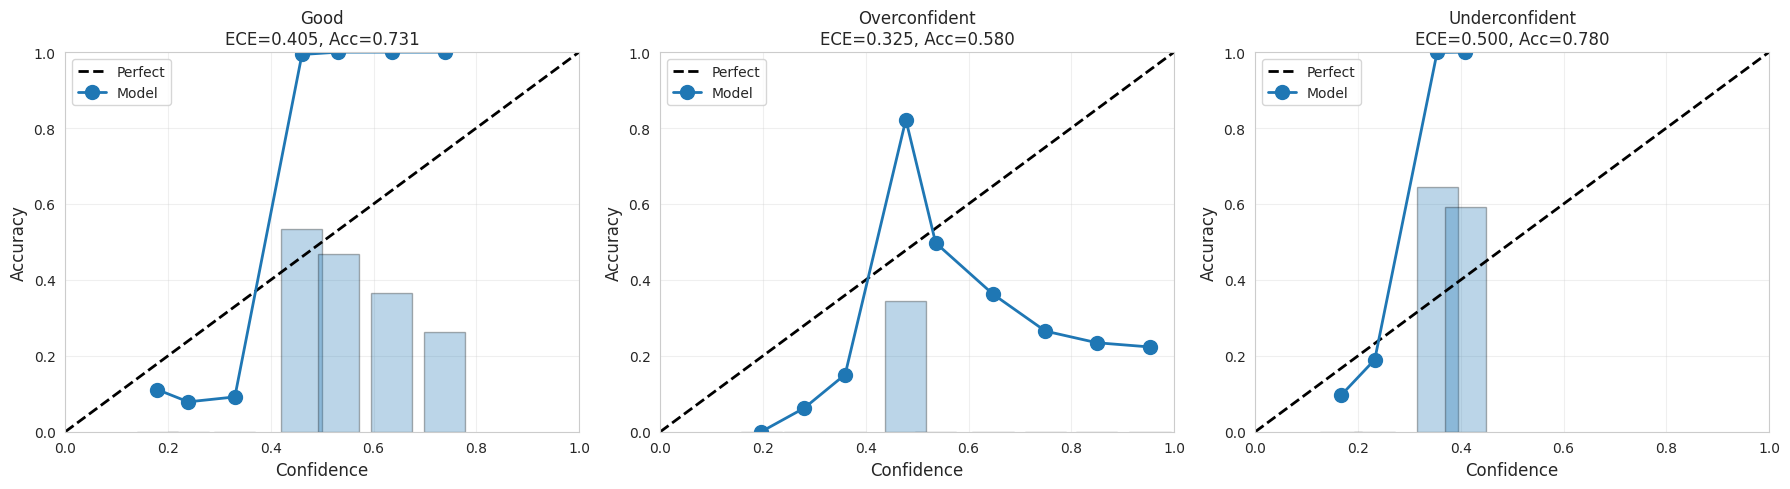

In [ ]:
# Visualize all three scenarios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, scenario in enumerate(scenarios):
    r = results[scenario]
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        r['confidences'], r['predictions'], r['labels'], n_bins=10)

    valid = ~np.isnan(bin_conf)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
    axes[idx].plot(bin_conf[valid], bin_acc[valid], 'o-',
                   linewidth=2, markersize=10, label='Model')

    gap = bin_acc - bin_conf
    axes[idx].bar(bin_conf[valid], gap[valid], width=0.08,
                  alpha=0.3, edgecolor='black')

    axes[idx].set_xlabel('Confidence', fontsize=12)
    axes[idx].set_ylabel('Accuracy', fontsize=12)
    axes[idx].set_title(f'{scenario.capitalize()}\n' +
                       f'ECE={r["ece"]:.3f}, Acc={r["accuracy"]:.3f}',
                       fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

**Key Observations**:

- **Well-calibrated model**: Points near diagonal, low ECE
- **Overconfident model**: Points below diagonal (confidence > accuracy), high ECE
- **Underconfident model**: Points above diagonal (accuracy > confidence), moderate ECE

**Important**: Calibration and accuracy are **independent**! A model can be:
- Accurate but poorly calibrated
- Well-calibrated but inaccurate
- Both accurate and well-calibrated (ideal)

## Part 3: Calibration Techniques

### Theoretical Background

Modern neural networks are often miscalibrated, especially when using techniques like:
- Batch normalization
- Large model capacity
- Modern architectures (ResNet, DenseNet, etc.)

Fortunately, we can **post-hoc calibrate** models without retraining. These techniques adjust predicted probabilities to better match actual accuracy.

#### Temperature Scaling

**Temperature scaling** is the simplest and most effective calibration method:

$$\hat{q}_i = \max_k \frac{\exp(z_k/T)}{\sum_j \exp(z_j/T)}$$

where:
- $z$ are the logits (pre-softmax outputs)
- $T > 0$ is the temperature parameter
- $T = 1$ gives original softmax
- $T > 1$ "softens" the distribution (less confident)
- $T < 1$ "sharpens" the distribution (more confident)

**Key properties**:
- Single scalar parameter $T$
- Optimized on validation set using negative log-likelihood
- Preserves model accuracy (predictions don't change)
- Fast and simple to implement
- Remarkably effective in practice

**Finding optimal temperature**:
$$T^* = \arg\min_T \text{NLL}(T) = \arg\min_T -\sum_i \log \hat{q}_i(y_i|T)$$

#### Other Calibration Methods

**Platt Scaling**:
- Fits logistic regression on top of model outputs
- Learns parameters $a$ and $b$: $p = \sigma(az + b)$
- More flexible than temperature scaling
- Originally designed for SVMs, works for neural networks

**Isotonic Regression**:
- Non-parametric calibration
- Learns monotonic mapping from confidence to calibrated probability
- More flexible but can overfit

<div class="alert alert-warning">
<b>Exercise 2 (15 minutes): Implementing Temperature Scaling</b>

Your task is to implement the temperature scaling method:

1. Using the provided class, fill the methods to calibrate and find an optimal temprature parameter on a calibration dataset using the CNN model.
2. Compare the impact of ECE, confidence and reliability diagram between a uncalibrated model and a calibrated model.
</div>

In [ ]:
class TemperatureScaling(nn.Module):
    """
    Temperature scaling for model calibration.
    """
    def __init__(self):
        super().__init__()
        #Init
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        """
        Apply temperature scaling to logits.
        """
        # TO FILL 
        return ""

    def calibrate(self, logits, labels, lr=0.01, max_iter=100):
        """
        Optimize temperature on validation set.

        Args:
            logits: model logits (N, C)
            labels: true labels (N,)
        """
        logits = torch.FloatTensor(logits)
        labels = torch.LongTensor(labels)

        # TO FILL (Hint: Use some optimizer e.g Adam)

        return self.temperature.item()




In [ ]:
# Run this after filling the TemperatureScaling class

# Split data into calibration and test sets
cal_logits, test_logits, cal_labels, test_labels = train_test_split(
    logits_true, labels_true, test_size=0.5, random_state=42)

print(f"Calibration set: {len(cal_labels)} samples")
print(f"Test set: {len(test_labels)} samples")

# Create temperature scaling object
temp_scaler = TemperatureScaling()

# Find optimal temperature on calibration set
optimal_temp = temp_scaler.calibrate(cal_logits, cal_labels)
print(f"\nOptimal temperature: {optimal_temp:.3f}")

# Apply temperature scaling to test set
with torch.no_grad():
    test_logits_tensor = torch.FloatTensor(test_logits)
    scaled_logits = temp_scaler(test_logits_tensor)
    calibrated_probs = F.softmax(scaled_logits, dim=1).numpy()

# Get uncalibrated predictions and confidences for the test set
orig_probs = F.softmax(torch.FloatTensor(test_logits), dim=1).numpy()
orig_preds = np.argmax(orig_probs, axis=1)
orig_conf = np.max(orig_probs, axis=1)

# Get calibrated predictions and confidences
calib_preds = np.argmax(calibrated_probs, axis=1)
calib_conf = np.max(calibrated_probs, axis=1)

# Compute metrics
print("\nBefore Temperature Scaling:")
print(f"  Accuracy: {accuracy_score(test_labels, orig_preds):.4f}")
print(f"  ECE: {compute_ece(orig_conf, orig_preds, test_labels):.4f}")
print(f"  Mean confidence: {orig_conf.mean():.4f}")

print("\nAfter Temperature Scaling:")
print(f"  Accuracy: {accuracy_score(test_labels, calib_preds):.4f}")
print(f"  ECE: {compute_ece(calib_conf, calib_preds, test_labels):.4f}")
print(f"  Mean confidence: {calib_conf.mean():.4f}")


# Compare reliability diagrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (conf, preds, title) in enumerate([
    (orig_conf, orig_preds, 'Before Temperature Scaling'),
    (calib_conf, calib_preds, 'After Temperature Scaling')
]):
    bin_conf, bin_acc, bin_counts = compute_calibration_bins(
        conf, preds, test_labels, n_bins=10)

    valid = ~np.isnan(bin_conf)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
    axes[idx].plot(bin_conf[valid], bin_acc[valid], 'o-',
                   linewidth=2, markersize=10, label='Model')

    gap = bin_acc - bin_conf
    axes[idx].bar(bin_conf[valid], gap[valid], width=0.08,
                  alpha=0.3, edgecolor='black')

    ece = compute_ece(conf, preds, test_labels)
    acc = accuracy_score(test_labels, preds)

    axes[idx].set_xlabel('Confidence', fontsize=13)
    axes[idx].set_ylabel('Accuracy', fontsize=13)
    axes[idx].set_title(f'{title}\nECE={ece:.4f}, Acc={acc:.4f}', fontsize=13)
    axes[idx].legend(fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

**Observation**: Temperature scaling:
- **Improves calibration** (lower ECE, points closer to diagonal)
- **Preserves accuracy** (predictions remain the same)
- **Reduces overconfidence** (lowers mean confidence)
- **Single parameter** (T) is sufficient for good results

**Comparison of Methods**:

- **Temperature Scaling**: Simple, effective, single parameter
- **Platt Scaling**: More flexible, can model non-linear calibration
- **Isotonic Regression**: Most flexible, but can overfit

**Recommendations**:
1. **Start with temperature scaling**: Usually sufficient and most robust
2. **Try Platt scaling**: If you need more flexibility
3. **Use isotonic regression**: Only with large validation sets
4. **Always validate**: Check calibration on held-out test set

## Part 4: Uncertainty quantification with Conformal prediction

### Theoretical Background
See https://github.com/deel-ai/puncc?tab=readme-ov-file#-documentation

Conformal Prediction (CP) is a set of methods to estimate uncertainty by constructing valid prediction sets, i.e., prediction sets with a probabilistic guarantee of marginal coverage.

Given an error rate (or significance level) $\alpha \in (0,1)$, set by the user, a set of exchangeable (or more simply i.i.d.) train data $\{ (X_i, Y_i) \}_{i=1}^{n}$ and a test point $(X_{new}, Y_{new})$, all of which are generated from the same joint distribution $\mathbb{P}_{XY}$, a conformal prediction procedure uses the training data to build prediction sets $\widehat{C}_{\alpha}(\cdot)$ so that:

$$\mathbb{P} \Big\{ Y_{new} \in \widehat{C}_{\alpha}\left(X_{new}\right) \Big\} \geq 1 - \alpha.$$

Over many calibration and test sets, $\widehat{C}_{\alpha}(X_{new})$ will contain the observed values of $Y_{new}$ with a frequency of at least $(1-\alpha)$.

**WARNING**: This is done **on average over all the calibration sets**, supposed to follow the same joint distribution. This is different than $$\mathbb{P}(\hat{Y} = y| X=x) = 1 - \alpha \quad \text{or more accurately} \quad \mathbb{P} \Big\{ Y_{new} \in \widehat{C}_{\alpha}\left(X_{new}\right) \mid X_{new}=x \Big\} \geq 1 - \alpha$$

Which is a more stronger guarantee, that one may achieve by prior knowledge on the model, distribution ...

### Simple example: Split Conformal Prediction

The dataset $D$ is split into a proper training set


$$D_{train}=\Big\lbrace(X_i,Y_i), i=1,\dots,n_{train}\Big\rbrace$$


and an independent calibration dataset


$$D_{calib}=\Big\lbrace(X_i,Y_i),i=1,\dots,n_{calib}\Big\rbrace.$$

The purpose of the calibration dataset is to estimate prediction errors and use them to build the prediction interval for a new sample $X_{new}$.

Given a prediction model $\widehat{f}$ trained on $D_{train}$, the algorithm is summarized in the following steps:

Define Nonconformity Score:
Choose a nonconformity score $s$, and define the error $R$ over a sample $(X,Y)$ as $R = s(\widehat{f}(X),Y)$.
For regression, the most common choice is the absolute deviation (residual):


$$R = |\widehat{f}(X)-Y|$$

Compute Calibration Scores:
Compute the nonconformity scores on the calibration dataset, forming the set:


$$\mathcal{R} = \{R_i\}_{i=1}^{n_{calib}}$$


where $R_i=s(\widehat{f}(X_i), Y_i)$ for all points in $D_{calib}$.

Compute Error Margin ($\delta_{\alpha}$):
Compute the error margin $\delta_{\alpha}$ as the required empirical quantile of $\mathcal{R}$.
The level of the quantile is calculated as:


$$\text{Quantile Level} = (1-\alpha) \left(1 + \frac{1}{n_{calib}}\right)$$

$$\delta_{\alpha} = \text{Quantile}_{\text{Level}}(\mathcal{R})$$

Build the Prediction Interval:
For a new input $X_{new}$, first get the model's point prediction $\widehat{f}(X_{new})$. The prediction interval $\widehat{C}_{\alpha}(X_{new})$ is constructed symmetrically around this prediction:

$$\widehat{C}_{\alpha}(X_{new}) = \Big[ \widehat{f}(X_{new}) - \delta_{\alpha} \,,\, \widehat{f}(X_{new}) + \delta_{\alpha} \Big]$$

This interval guarantees that the true value of $Y_{new}$ will be contained in $\widehat{C}_{\alpha}(X_{new})$ with probability at least $1-\alpha$.


In [ ]:
# Basic implementation of Split Conformal Regression

class SplitConformalRegressor():
    """
    
    This class implements the Split conformal regression method (classic method).
    Computes a quantile of absolute residuals to give a (marginal) 1-epsilon coverage guarantee
    on the calibration dataset
    To do:
        - Jacknife methods
        - Weighted conformal regression
        - Conformal quantile regression
        - Conformal classification (split, RAPS, rank ...)
    """
    
    def __init__(self,epsilon: float,model, X_c: np.ndarray, y_c: np.ndarray):
        """
        Args:
            model: A regressor model with a model.predict() method. E.g sklearn.BaseEstimator
            epsilon: Epsilon coverage value for split conformal prediction. Between 0 and 1
            X_c: Calibration features dataset
            y_c: Calibration target dataset
        """
         
        self.X_c = X_c
        self.y_c = y_c
        self.model = model
        self.epsilon = epsilon
        self.residuals = None
        self.n_calib = len(self.X_c)
        self.quantile = None
    def _compute_residuals(self, y_hat: float,y:float) -> float:
        """
        Compute the residuals between two values, predicted and ground truth
        Args:
          y_hat: predicted value
          y: ground_truth
        Return:
          absolute value of residual
        """
        return np.abs(y_hat-y)
    def make_one_pred(self, x_new: np.ndarray)-> float:
        """
        Compute a prediction with underlying model
        Args:
          x_new: An instance to infer on
        Return:
          Output from model
        """
        return self.model.predict(x_new)
    
    def calibrate(self):
        """
        Compute the set of residuals on all the calibration dataset
        """
        
        self.residuals = [self._compute_residuals(self.make_one_pred(self.X_c[i].reshape(-1,1)),
                                                  self.y_c[i])
                          for i in range(0,self.n_calib)
                         ]
    def conformalize(self):
        """
        Compute the quantile of residuals according to the coverage set
        Args:
            None. Ensure calibration steps has been done previously
        Return:
            quantiles: list of error quantile for each corners
        """
        if len(self.residuals) == 0:
            raise ValueError("Calibration should have been performed first !")
        
        sorted_residuals = np.sort(self.residuals, axis=0)
        k = int(np.floor((self.n_calib + 1) * (1 - self.epsilon)) + 1)
        self.quantile = sorted_residuals[k]
        quantile = self.quantile.copy()
        return quantile

    def compute_conformalized_interval(self, xs_new: np.ndarray) -> np.ndarray:
        """
        Compute the model prediction on an array of input features along with confidence bound 
        resulting from the calibrated and conformalized procedure
        Args:
          xs_new: Instance to infer on
        Return:
          intervals: A 3D array with
                    - Axis 0 : lower bound
                    - Axis 1 : prediction
                    - Axis 2: upper bound
        """
        if self.quantile is None:
            raise ValueError("Conformal quantile should have been computed first, see 'conformalize' method")
        intervals = np.zeros((len(xs_new),3)) # min, pred, max
        for i in range(0,len(xs_new)):
            y_new = self.make_one_pred(xs_new[i].reshape(-1,1))
            intervals[i,0] = y_new - self.quantile
            intervals[i,1] = y_new 
            intervals[i,2] = y_new + self.quantile
        return intervals

In [ ]:
def generate_samples():
    """
    Toy functuion to generate a linear noisy data
    """
    N = 10000
    X = np.linspace(-1,1,N)
    slope = 1
    intercept = 2
    Y = slope * X + intercept
    Y[0:2000] = np.random.normal(Y[0:2000], 1)
    Y[2000:4000] = np.random.normal(Y[2000:4000], 0.1)
    Y[4000:6000] = np.random.normal(Y[4000:6000], 1)
    Y[6000:8000] = np.random.normal(Y[6000:8000], 0.1)
    Y[8000::] = np.random.normal(Y[8000::], 1) 
    
    return X,Y


def split_train_calib_test(X: np.ndarray,
                           y: np.ndarray,
                           train_quota: float,
                           calib_quota: float,
                           test_quota: float) -> Tuple[np.ndarray]:
    """
    Custom splitting function to gather training, test and calibration data
    Args:
      X: Input features dataset
      y: Input target dataset
      train_quota: ratio of train set
      test_quota: ratio of test set
      calib_quota: ratio of calib set
    Return:
      Train, test and calibration features and targets
    Raises:
      ValueError when sum of ratio is not equal to 1
    """
    if (test_quota+  train_quota + calib_quota) != 1:
        raise ValueError("Sum of train, test, calib ratios should be one")
    X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=test_quota+calib_quota, random_state=42)
    X_c, X_test, y_c, y_test = train_test_split(
        X_test,y_test, test_size = test_quota / (test_quota + calib_quota)) 
    return X_train, y_train, X_test,y_test, X_c, y_c

epsilon=0.5
train_quota = 0.4
test_quota = 0.2
calib_quota  = 0.4
lin_model = LinearRegression()

X,y = generate_samples()
X_train, y_train, X_test, y_test, X_c, y_c = split_train_calib_test(X,y,train_quota, calib_quota, test_quota)


In [ ]:
# Plot original signal

plt.figure(figsize=(12,8))
plt.plot(X,y)

In [ ]:
# Plot only data used for calibration

plt.figure(figsize=(12,8))
plt.scatter(X_c,y_c)

In [ ]:
# Fit a Basic Linear model
lin_model.fit(X_train.reshape(-1,1), y_train)
lin_model.coef_

In [ ]:
conformalizer = SplitConformalRegressor(epsilon, lin_model, X_c.reshape(-1,1), y_c)
conformalizer.calibrate()
# This return the quantile value at desired level
conformalizer.conformalize()

In [ ]:
bins=20
plt.figure(figsize=(12, 8))
plt.hist(np.asarray(conformalizer.residuals), bins, histtype='step', cumulative=True, density=True, label='residual')
plt.legend(loc='upper right')
plt.xlabel(" Residual value")
plt.title("Cumulative distribution of absolute residuals")

In [ ]:
def plot_intervals(X_test,y_test, conformalized_intervals):
    plt.figure(figsize=(12, 8))
    plt.plot(X_test,y_test, '*')
    plt.plot(X_test, conformalized_intervals[:,1], 'rx')
    plt.plot(X_test, conformalized_intervals[:,0], 'r')
    plt.plot(X_test, conformalized_intervals[:,2], 'rx')
    plt.show()

# plotting for multiple coverage values
for epsilon in [0.5,0.3,0.1,0.05,0.02]:
    print(epsilon)
    conformalizer = SplitConformalRegressor(epsilon, lin_model, X_c.reshape(-1,1), y_c)
    conformalizer.calibrate()
    conformalizer.conformalize()
    print(conformalizer.quantile)
    intervals = conformalizer.compute_conformalized_interval(X_test.reshape(-1,1))
    plot_intervals(X_test,y_test, intervals)

**Key observations**

- **Distribution-free**. CP methods can be applied regardless of the underlying data-generating distribution.

- **Model-agnostic**. CP works with any ML model, even with black-box models where we only have access to the outputs of the model.

- **Non-asymptotic**. CP methods provide finite-sample probabilistic guarantees, that is, the guarantees hold without the need to assume that the number of available data grows to infinity.
- Split conformal Regression will output a constant interval which is not suited for a lot of cases as seen in the exemple. Adapted methods exists (e.g. Conformal Quantile Regression)
- No magic, the more restrictive the coverage, the larger the prediction interval ! Also uf the underlying model has bad predictions, you will just add your error rate on top of errors! Looking at the coverage and size of the interval is a good measure of how well the model is performing !

### Conformal Classification

We now adapt the split conformal method for classification. The goal is to create a set of predicted classes that contains the true class with a high probability (e.g., 90%).

1.  **Non-conformity Score**: A common choice is $s(x, y) = 1 - \hat{p}_y$, where $\hat{p}_y$ is the model's predicted softmax probability for the true class $y$. A high score means the model was not confident in the correct class.

2.  **Calibration**: We compute these scores for all samples in the calibration set.

3.  **Quantile**: We find the quantile $q$ of these scores that corresponds to our desired coverage level $1-\alpha$. Specifically, $q$ is the value at index $\lceil (1-\alpha)(n_{calib}+1) \rceil$ of the sorted scores.

4.  **Prediction Set**: For a new image, the prediction set consists of all classes $k$ whose probability $\hat{p}_k$ satisfies $1 - \hat{p}_k \leq q$, which is equivalent to $\hat{p}_k \geq 1-q$.

<div class="alert alert-warning">
<b>Exercise 3 (15 minutes): Implement conformal classification</b>

Your task is to adapt the previous algorithm for classification. Using the previous calibration and test set **cal_logits**, **cal_labels**, **test_logits**, **test_labels**

1. Implement the conformal prediction framework to compute scores (using softmax) on the calibration set
2. For a given alpha, retrieve the quantile at desired coverage level. 
3. For a given image from CIFAR10 (e.g. cat.jpg image from Model_Analsis notebook), compute the conformalized output. Observe how the size of the prediction set varies. What can you say about this model that has not been trained on CIFAR10 images ?



In [6]:
# Exercice 3: Your code here ...

## Conclusion

In this notebook, we've explored the critical topics of **uncertainty quantification** and **calibration** in deep learning:

### Key Takeaways

**Uncertainty Quantification:**
- Two types: **aleatoric** (data uncertainty) and **epistemic** (model uncertainty)
- MC Dropout provides practical epistemic uncertainty estimates
- Uncertainty helps identify when models are likely to be wrong
- Essential for safety-critical applications and active learning

**Calibration:**
- Modern neural networks are often **overconfident**
- Calibration is **independent of accuracy**—a model can be accurate but miscalibrated
- **Reliability diagrams** visualize calibration quality
- **ECE and MCE** quantify calibration error

**Calibration Techniques:**
- **Temperature scaling** is simple, effective, and preserves accuracy
- Post-hoc calibration requires only a small validation set
- Always evaluate calibration on held-out data
- Different applications may need different calibration methods

### Practical Guidelines

When deploying models in practice:

1. **Always check calibration** before deployment
2. **Use temperature scaling** as a default calibration method
3. **Reserve data for calibration** (typically 10-20% of validation set)
4. **Monitor both accuracy and calibration** in production
5. **Consider uncertainty** when making decisions, especially in high-stakes scenarios
6. **Reject uncertain predictions** when appropriate
7. **Recalibrate periodically** as data distributions shift

### When Uncertainty and Calibration Matter Most

These techniques are especially important for:
- **Medical diagnosis**: Need reliable confidence for treatment decisions
- **Autonomous driving**: Safety-critical decisions require knowing when the model is uncertain
- **Financial trading**: Risk assessment depends on accurate probability estimates
- **Legal applications**: Decisions affecting people's lives need trustworthy predictions
- **Active learning**: Selecting informative samples to label next
- **Out-of-distribution detection**: Identifying inputs the model hasn't seen

### Further Topics

To deepen your understanding:
1. **Bayesian deep learning**: Full posterior over model weights
2. **Evidential deep learning**: Direct uncertainty estimation
3. **Conformal prediction**: Distribution-free uncertainty quantification
4. **Test-time augmentation**: Another approach to uncertainty
5. **Calibration in regression**: ECE for continuous predictions
6. **Class-conditional calibration**: Different calibration per class

### The Bottom Line

**Accuracy alone is not enough.** In the real world, knowing **when to trust** a model is as important as having a model that performs well on average. Uncertainty quantification and calibration provide the tools to build models that are not just accurate, but also **trustworthy** and **reliable**.

## References

1. Guo, C., et al. (2017). On Calibration of Modern Neural Networks. *ICML*.
2. Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian Approximation. *ICML*.
3. Kendall, A., & Gal, Y. (2017). What Uncertainties Do We Need in Bayesian Deep Learning? *NeurIPS*.
4. Platt, J. (1999). Probabilistic Outputs for Support Vector Machines. *Advances in Large Margin Classifiers*.
5. Naeini, M. P., et al. (2015). Obtaining Well Calibrated Probabilities Using Bayesian Binning. *AAAI*.
6. Ovadia, Y., et al. (2019). Can You Trust Your Model's Uncertainty? *NeurIPS*.
7. Lakshminarayanan, B., et al. (2017). Simple and Scalable Predictive Uncertainty Estimation. *NeurIPS*.